In [1]:
import glob
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

In [10]:
root_dir = "/app/_data/artist_data/"
SEED = 39
BATCH_SIZE = 32
IMG_SIZE = (512, 81)
N_FOLDS = 6
NORM = False
N_CHANELS = 1

In [3]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))

## train_val_split

In [4]:
gkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=6.
  warnings.warn(


In [6]:
FOLD = 0
artist_ids = train["artistid"].unique().tolist()
train_set = train[train["fold"] != FOLD]["artistid"].unique()
val_set = train[train["fold"] == FOLD]["artistid"].unique()
train_data, val_data = {}, {}
for art_id in tqdm(artist_ids):
    new_df = train.query("artistid == @art_id")
    paths = new_df["path"].values.tolist()
    tracks = new_df["trackid"].values.tolist()
    if art_id in train_set:
        train_data[art_id] = {
            "tracks": tracks,
            "paths": paths,
            "count": new_df.shape[0],
        }
    else:
        val_data[art_id] = {"tracks": tracks, "paths": paths, "count": new_df.shape[0]}

100% 18468/18468 [00:41<00:00, 441.42it/s]


## DataGenerator

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, img_size, batch_size, norm, n_chanels, shuffle):
        self.data = data
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        if self.n_chanels is None:
            self.n_chanels = 1
        self.shuffle = shuffle
        self.artist_ids = [x for x in self.data.keys()]
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def __len__(self):
        return len(self.artist_ids) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.artist_ids)

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels != 1:
            img = np.concatenate([img, img, img], -1)
        return img

    def make_pair(self, ix, pos_label):
        artist_id = self.artist_ids[ix]
        if self.data[artist_id]["count"] < 2:
            pos_label = False
        if pos_label:
            path1, path2 = rnd.sample(self.data[artist_id]["paths"], 2)
        else:
            path1 = rnd.sample(self.data[artist_id]["paths"], 1)[0]
            new_artist_id = artist_id
            while artist_id == new_artist_id:
                new_artist_id = rnd.sample(self.artist_ids, 1)[0]
                path2 = rnd.sample(self.data[new_artist_id]["paths"], 1)[0]
        return pos_label, (path1, path2)

    def _get_one(self, ix, pos_label):
        upd_pos_label, [path1, path2] = self.make_pair(ix=ix, pos_label=pos_label)
        img1 = self.load_img(path1)
        img2 = self.load_img(path2)
        y = 0 if pos_label else 1
        return (img1, img2), y

    def __getitem__(self, batch_ix):
        b_X1 = np.zeros(
            (self.batch_size, self.img_size[0], self.img_size[1], self.n_chanels),
            dtype=np.float32,
        )
        b_X2 = np.zeros(
            (self.batch_size, self.img_size[0], self.img_size[1], self.n_chanels),
            dtype=np.float32,
        )
        b_Y = np.zeros(
            self.batch_size,
            dtype=np.uint8,
        )
        for i in range(self.batch_size):
            pos_label = np.random.random() > 0.5
            (b_X1[i], b_X2[i]), b_Y[i] = self._get_one(
                i + self.batch_size * batch_ix, pos_label
            )
        return {"input1": b_X1, "input2": b_X2, "target": b_Y}

In [12]:
train_gen = DataGenerator(
    data=train_data,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    norm=NORM,
    n_chanels=N_CHANELS,
    shuffle=True,
)
val_gen = DataGenerator(
    data=val_data,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    norm=NORM,
    n_chanels=N_CHANELS,
    shuffle=False,
)

In [18]:
sample_batch = train_gen.__getitem__(np.random.randint(train_gen.__len__()))
sample_batch["input1"].shape
sample_batch["input2"].shape
sample_batch["target"].shape

(32, 512, 81, 1)

(32, 512, 81, 1)

(32,)

In [19]:
sample_batch["target"]

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0], dtype=uint8)

### balance between 1 and 0

In [22]:
tgs = []
for i in tqdm(range(train_gen.__len__())):
    a = train_gen.__getitem__(i)
    tgs.append(a["target"].mean())
print(f"{np.mean(tgs):.3f} of negative pairs, {1 - np.mean(tgs):.3f} of negative pairs")

100% 480/480 [00:10<00:00, 43.88it/s]

0.500 of negative pairs, 0.500 of negative pairs


In [30]:
def plot_layer(input_img, x, ix):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title("Original image")
    plt.imshow(input_img.numpy()[ix, :, :, 0].transpose(1, 0)[:200])
    plt.subplot(2, 1, 2)
    plt.title("Transformed image")
    plt.imshow(x.numpy()[ix, :, :, 0].transpose(1, 0)[:200])

In [298]:
# input = tf.keras.layers.Input(( 512, 81, 1))
a = train_gen.__getitem__(55)
input = tf.convert_to_tensor(a["input1"])
x = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(
    4,
    (10, 5),
    activation="relu",
)(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(
    16,
    (10, 5),
    activation="relu",
)(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(
    64,
    (10, 5),
    activation="relu",
)(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x.shape

TensorShape([16, 56, 6, 64])

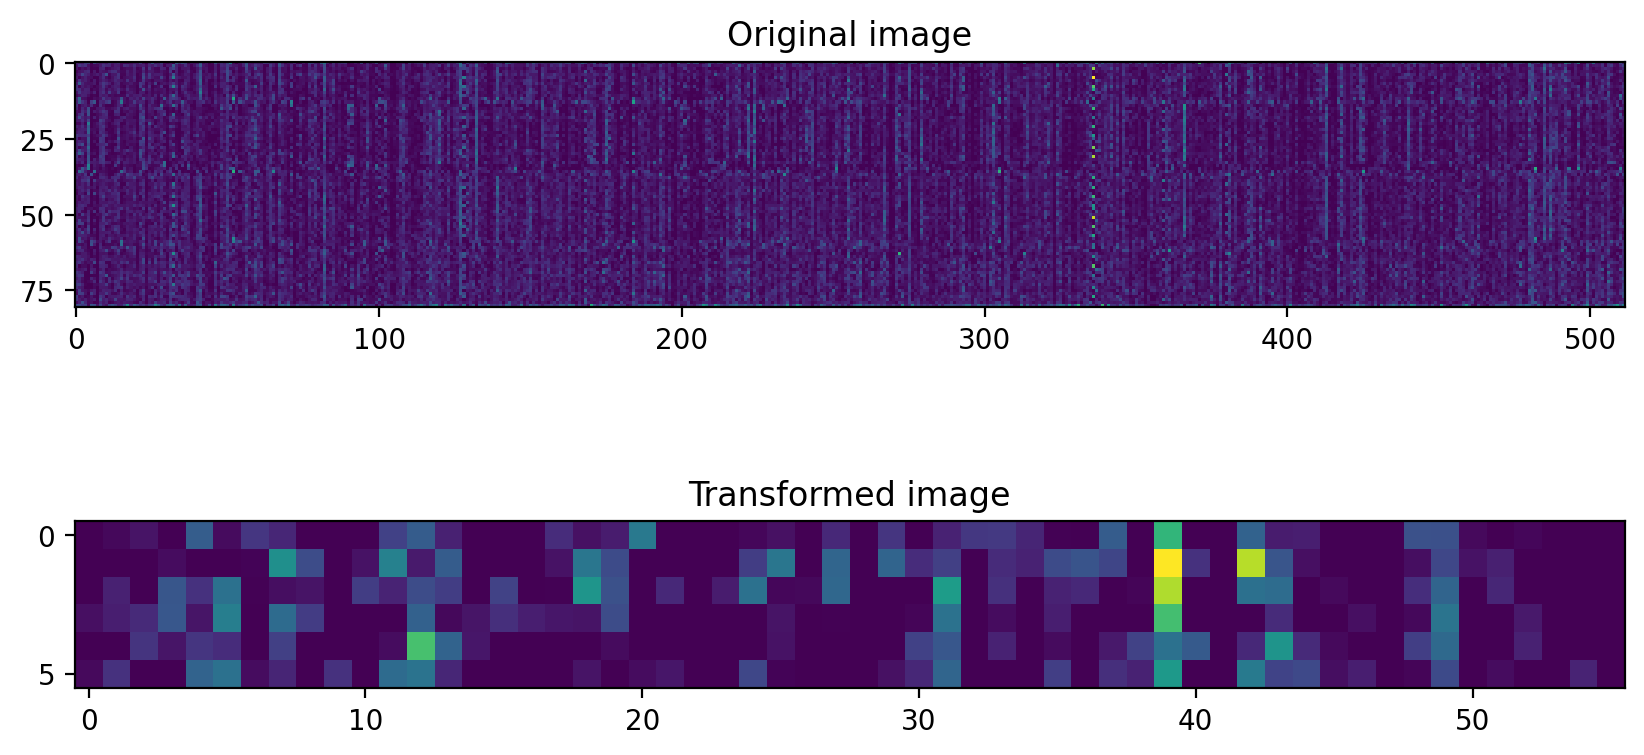

In [299]:
plot_layer(input, x, 1)

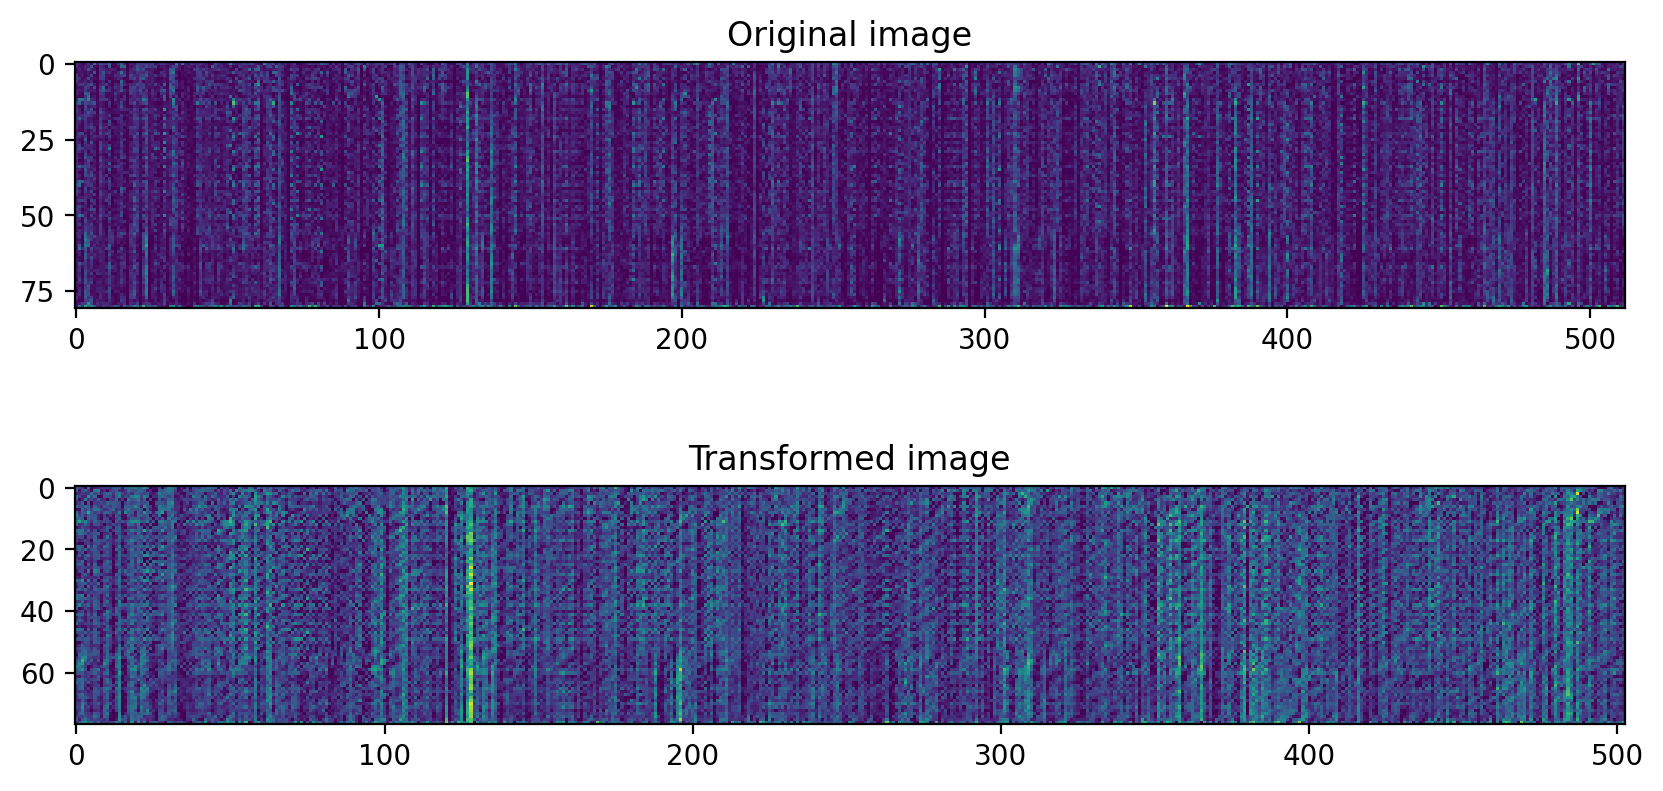

In [283]:
plot_layer(input, x, 1)

In [ ]:
input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [301]:
a = train_gen.__getitem__(55)
tinput = tf.convert_to_tensor(a["input1"])

## Build model

In [341]:
def make_effnet_model(input_shape):
    base_model = keras.applications.efficientnet.EfficientNetB0(
        include_top=False,
        weights=None,
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
    )
    input1 = keras.layers.Input(shape=input_shape)
    x = base_model(input)
    x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(5096, activation="tanh")(x)
    x = keras.layers.BatchNormalization()(x)
    output = keras.layers.Dense(1024, activation="tanh")(x)
    model = keras.Model(inputs=input, outputs=output)
    return model

In [73]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [75]:
x1 = tf.constant(np.random.random((16, 1024)))
x2 = tf.constant(np.random.random((16, 1024)))
euclidean_distance([x1, x2])
euclidean_distance_k([x1, x2])
keras.layers.BatchNormalization()(euclidean_distance([x1, x2]))

<tf.Tensor: shape=(16, 1), dtype=float64, numpy=
array([[12.43375417],
       [13.02545439],
       [13.6707281 ],
       [13.23537135],
       [13.18534986],
       [13.40771505],
       [13.21354575],
       [13.15565094],
       [13.04039777],
       [13.33608828],
       [13.14553117],
       [13.02038041],
       [13.00168994],
       [12.93675146],
       [12.7843471 ],
       [13.15751239]])>

<tf.Tensor: shape=(16, 1), dtype=float64, numpy=
array([[12.43375417],
       [13.02545439],
       [13.6707281 ],
       [13.23537135],
       [13.18534986],
       [13.40771505],
       [13.21354575],
       [13.15565094],
       [13.04039777],
       [13.33608828],
       [13.14553117],
       [13.02038041],
       [13.00168994],
       [12.93675146],
       [12.7843471 ],
       [13.15751239]])>

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[12.427541 ],
       [13.018946 ],
       [13.663897 ],
       [13.228758 ],
       [13.1787615],
       [13.401015 ],
       [13.2069435],
       [13.149077 ],
       [13.033882 ],
       [13.329425 ],
       [13.138963 ],
       [13.013874 ],
       [12.9951935],
       [12.930287 ],
       [12.77796  ],
       [13.150938 ]], dtype=float32)>

In [84]:
def make_model(input_shape, embedding_len=1024, kernel_size=(10, 3)):
    def euclidean_distance(vects):
        x, y = vects
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

    def embedding_model():
        input = keras.layers.Input(input_shape)
        x = keras.layers.BatchNormalization()(input)
        x = keras.layers.Conv2D(4, kernel_size, activation="tanh", name="Conv2D_1")(x)
        x = keras.layers.AveragePooling2D(pool_size=(2, 2), name="avg_pool_1")(x)
        x = keras.layers.Conv2D(16, kernel_size, activation="tanh", name="Conv2D_2")(x)
        x = keras.layers.AveragePooling2D(pool_size=(2, 2), name="avg_pool_2")(x)
        x = keras.layers.Conv2D(64, kernel_size, activation="tanh", name="Conv2D_3")(x)
        x = keras.layers.AveragePooling2D(pool_size=(2, 2), name="avg_pool_3")(x)
        x = keras.layers.Conv2D(128, kernel_size, activation="tanh", name="Conv2D_4")(x)
        x = keras.layers.AveragePooling2D(pool_size=(2, 2), name="avg_pool_4")(x)
        x = keras.layers.Flatten(name="flatten")(x)
        x = keras.layers.BatchNormalization(name="batch_norm_1")(x)
        x = keras.layers.Dense(
            embedding_len, activation="tanh", name=f"dense_{embedding_len}"
        )(x)
        embedding_network = keras.Model(inputs=input, outputs=x, name=f"embedding")
        return embedding_network

    input_1 = keras.layers.Input(input_shape, name="input1")
    input_2 = keras.layers.Input(input_shape, name="input2")
    base_model = embedding_model()
    node1 = base_model(input_1)
    node2 = base_model(input_2)

    merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
    output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    return siamese

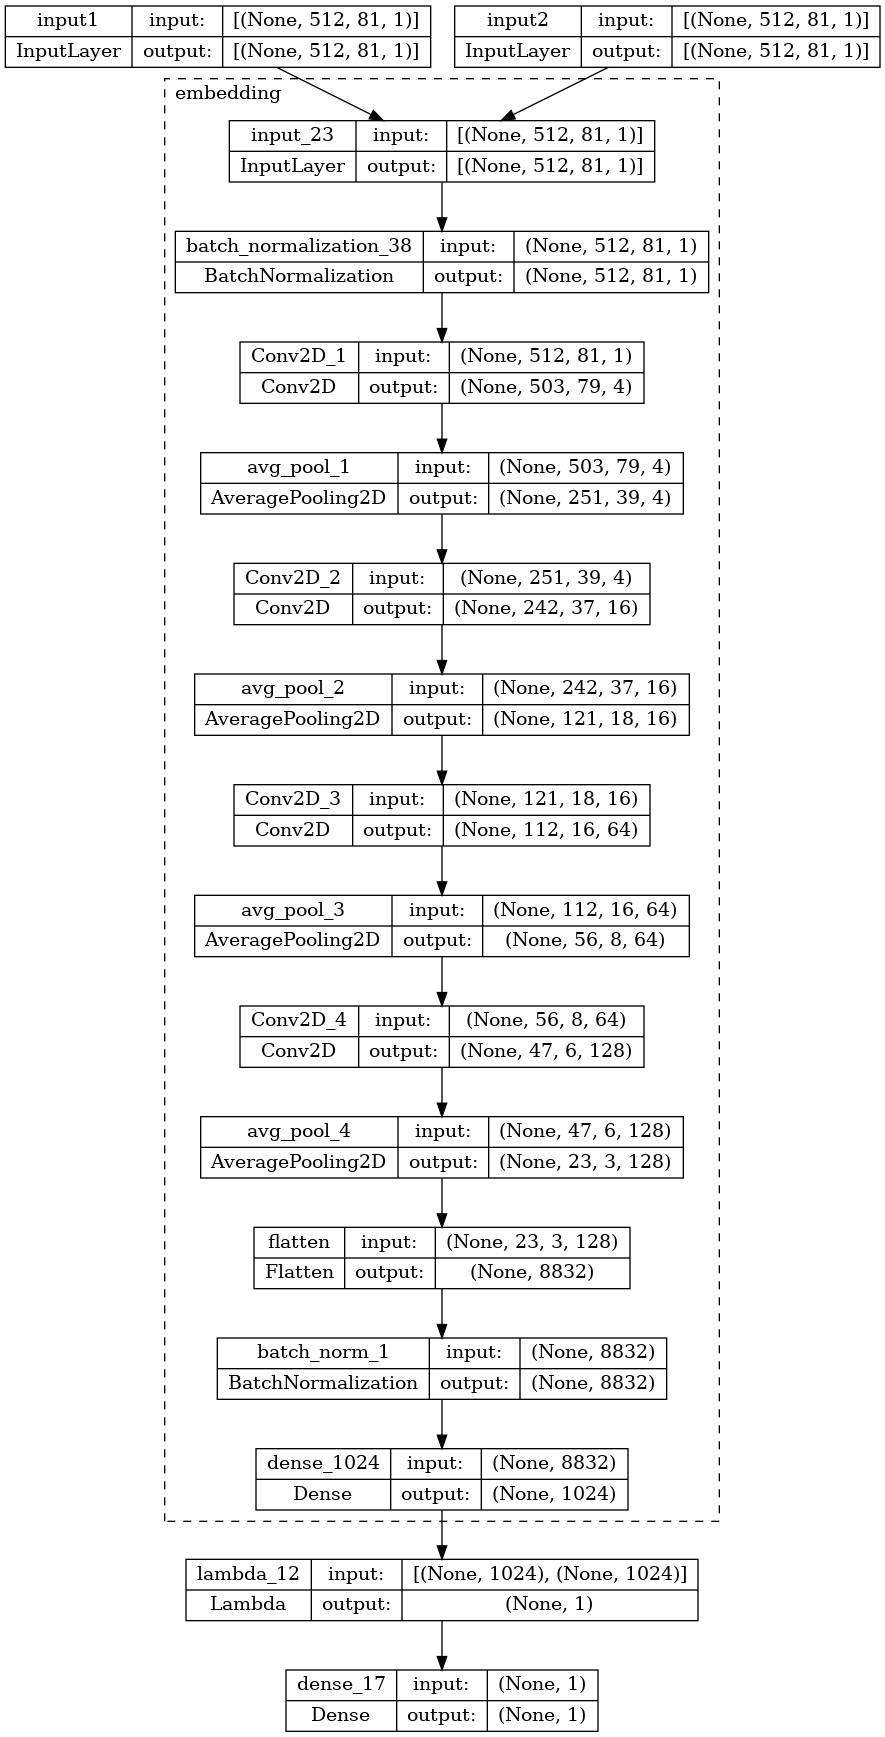

In [79]:
tf.keras.utils.plot_model(
    make_model(input_shape=a["input1"].shape[1:]),
    to_file="mod.png",
    show_shapes=True,
    expand_nested=True,
)

In [36]:
train_gen = DataGenerator(
    data=train_data,
    img_size=(512, 81),
    batch_size=16,
    norm=True,
    n_chanels=1,
    shuffle=True,
)
a = train_gen.__getitem__(4)

In [37]:
a["input1"].shape

(16, 512, 81, 1)

In [85]:
model = make_model(
    input_shape=a["input1"].shape[1:], embedding_len=1024, kernel_size=(10, 3)
)

In [86]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [87]:
model.compile(loss=loss(margin=1), optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 512, 81, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input2 (InputLayer)            [(None, 512, 81, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 embedding (Functional)         (None, 1024)         9359056     ['input1[0][0]',                 
                                                                  'input2[0][0]']          